# Máy học nâng cao - Lab 07
# Họ tên: Nguyễn Phú Thành - MSSV: 18110014

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from matplotlib import pyplot as plt

In [2]:
batch_size = 128
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test]) 
all_digits = (all_digits.astype("float32")-127.5) / 127.5
all_digits = np.reshape(all_digits,(-1,28,28,1))
dataset=tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

11501568/11490434 [==============================] - 0s 0us/step


# Bài tập
## 1. Dựa vào mô hình GAN, hãy tạo ra một mô hình DCGAN và train trên tập Mnist


In [3]:
class DeepConvGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DeepConvGAN, self).__init__()
        self.discriminator = discriminator 
        self.generator = generator
        self.latent_dim = latent_dim
    def compile(self, d_optimizer, g_optimizer, loss_function):
        super(DeepConvGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_function = loss_function 
    def train_step(self, real_images):
        # tạo batch size từ dữ liệu đầu vào
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape = (batch_size, self.latent_dim)) #tạo noises theo phân phối chuẩn

        # Tạo ra ảnh giả từ mạng generator
        generated_images = self.generator(random_latent_vectors)

        # nối ảnh giả và ảnh thật làm bộ dữ liệu cho mô hình discriminator
        combined_images = tf.concat([generated_images, real_images], axis = 0)

        # Ở đây đánh nhãn ảnh thật là 0, ảnh giả là 1
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis = 0
        )
        # trick để add thêm noise cho nhãn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # huấn luyện discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images) # Dự đoán 
            d_loss = self.loss_function(labels, predictions)  #Đưa kết quả dự đoán và grouth-truth vào hàm loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        ) #cập nhật weights cho mô hình discrimunator


        # lặp lại bước tạo noise như ở trên
        random_latent_vectors = tf.random.normal(shape = (batch_size, self.latent_dim))

        # tạo mộ bộ nhãn sao cho đều là 0 để đánh lừa discriminator
        misleading_labels = tf.zeros((batch_size, 1))

        # Train generator (lưu ý k update weights cho discriminator)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_function(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [4]:
class DeepConvGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img = 3, latent_dim = 100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs = None):
        random_latent_vectors = tf.random.normal(shape = (self.num_img, self.latent_dim)) #Tạo noises
        generated_images = self.model.generator(random_latent_vectors) #tạo ảnh
        generated_images = generated_images*127.5 + 127.5 #Đưa ảnh về [0,255]
        plt.close("all")
        print(f">> Images generated in epoch = {epoch + 1}:")
        fig, axes = plt.subplots(nrows = 1, ncols = self.num_img, figsize = (20, self.num_img))
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            axes[i].imshow(img, cmap = plt.cm.gray)
            _ = axes[i].set(xticks = [], yticks = [])
        plt.show()

Generator:

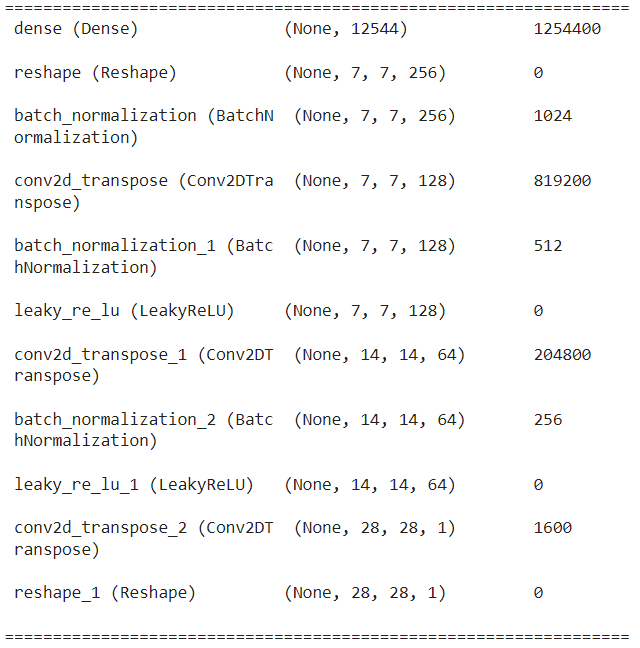

In [5]:
# Generator model
latent_dim = 100
inputs_gen = tf.keras.layers.Input(shape = (latent_dim,))
dense_gen = tf.keras.layers.Dense(units = 7*7*256, use_bias = False)(inputs_gen)
reshape_gen = tf.keras.layers.Reshape((7, 7, 256))(dense_gen)
batch_norm_1_gen = tf.keras.layers.BatchNormalization()(reshape_gen)
conv2d_t1_gen = tf.keras.layers.Convolution2DTranspose(
    filters = 128, 
    kernel_size = (5, 5), 
    strides = (1, 1),
    padding = "same",
    use_bias = False
)(batch_norm_1_gen)
batch_norm_2_gen = tf.keras.layers.BatchNormalization()(conv2d_t1_gen)
lrelu_1_gen = tf.keras.layers.LeakyReLU(alpha = 0.2)(batch_norm_2_gen)
conv2d_t2_gen = tf.keras.layers.Convolution2DTranspose(
    filters = 64, 
    kernel_size = (5, 5), 
    strides = (2, 2),
    padding = "same",
    use_bias =  False
)(lrelu_1_gen)
batch_norm_3_gen = tf.keras.layers.BatchNormalization()(conv2d_t2_gen)
lrelu_2_gen = tf.keras.layers.LeakyReLU(alpha = 0.2)(batch_norm_3_gen)
conv2d_t3_gen = tf.keras.layers.Convolution2DTranspose(
    filters = 1, 
    kernel_size = (5, 5), 
    strides = (2, 2),
    padding = "same",
    use_bias = False,
    activation = "tanh"
)(lrelu_2_gen)
reshape_2  = tf.keras.layers.Reshape((28, 28, 1))(conv2d_t3_gen)
generator = tf.keras.models.Model(inputs = inputs_gen, outputs = reshape_2)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        512   

Discriminator:

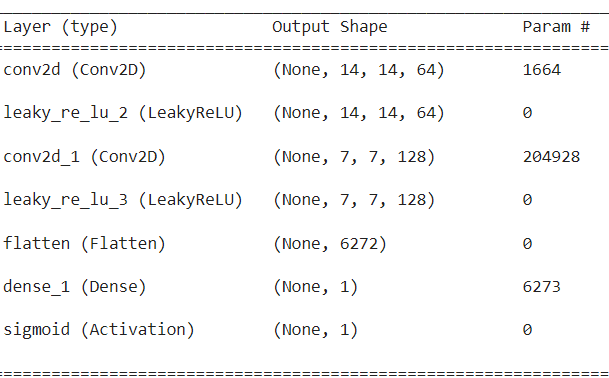

In [6]:
# Discriminator model
inputs_dis = tf.keras.layers.Input(shape = (28, 28, 1))
conv_1 = tf.keras.layers.Convolution2D(
    filters = 64,
    kernel_size = (5, 5),
    strides = (2, 2),
    padding = "same",
)(inputs_dis)
lrelu_1_dis = tf.keras.layers.LeakyReLU(alpha = 0.2)(conv_1)
conv_2 = tf.keras.layers.Convolution2D(
    filters = 128,
    kernel_size = (5, 5),
    strides = (2, 2),
    padding = "same",
)(lrelu_1_dis)
lrelu_2_dis = tf.keras.layers.LeakyReLU(alpha = 0.2)(conv_2)
flatten = tf.keras.layers.Flatten()(lrelu_2_dis)
dense_dis = tf.keras.layers.Dense(units = 1)(flatten)
activation_dis = tf.keras.layers.Activation("sigmoid")(dense_dis)

discriminator = tf.keras.models.Model(inputs = inputs_dis, outputs = activation_dis)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273

>> Images generated in epoch = 1:


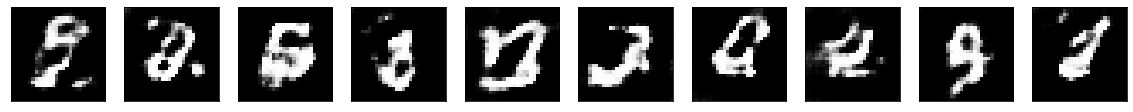

>> Images generated in epoch = 2:


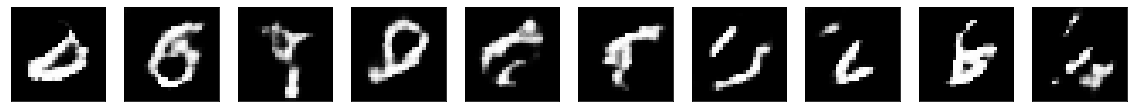

>> Images generated in epoch = 3:


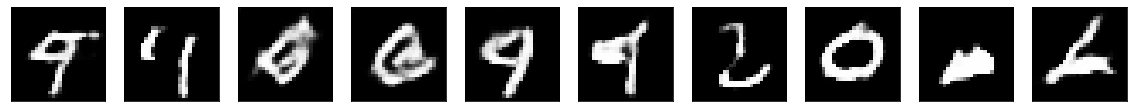

>> Images generated in epoch = 4:


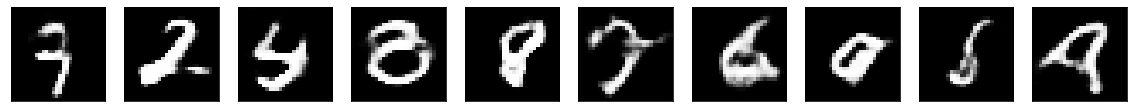

>> Images generated in epoch = 5:


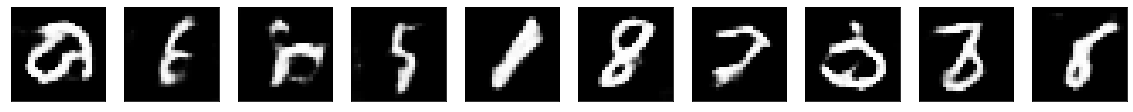

>> Images generated in epoch = 6:


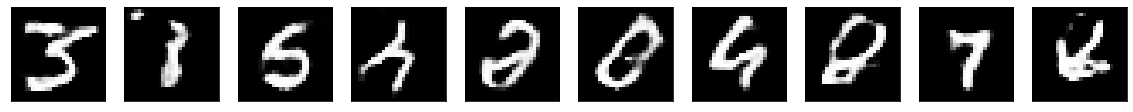

>> Images generated in epoch = 7:


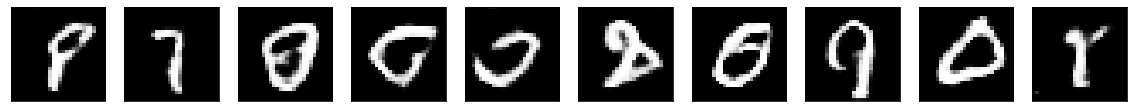

>> Images generated in epoch = 8:


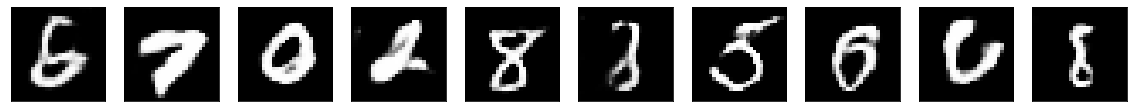

>> Images generated in epoch = 9:


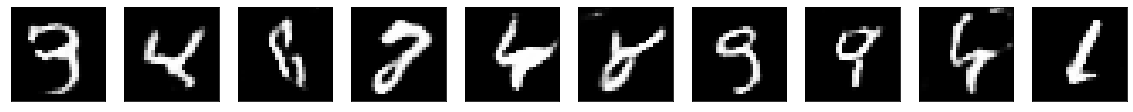

>> Images generated in epoch = 10:


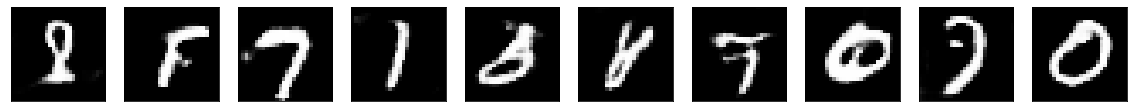

>> Images generated in epoch = 11:


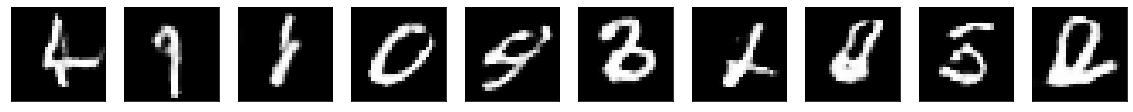

>> Images generated in epoch = 12:


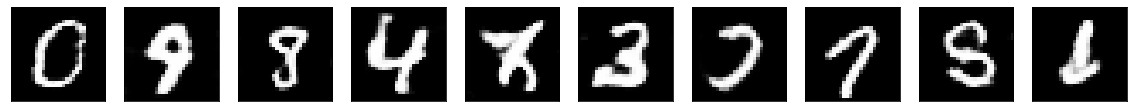

>> Images generated in epoch = 13:


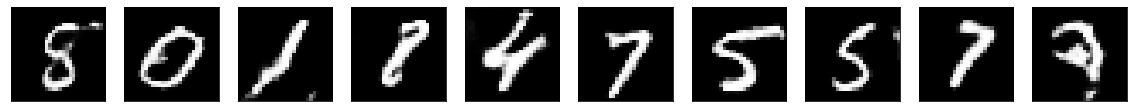

>> Images generated in epoch = 14:


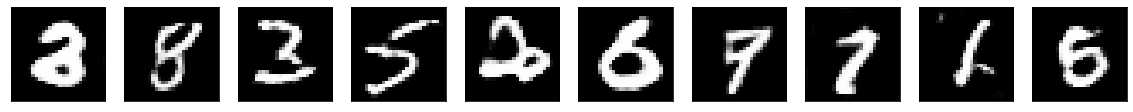

>> Images generated in epoch = 15:


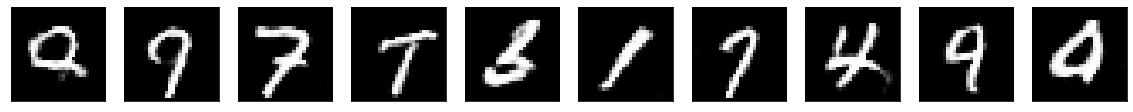

>> Images generated in epoch = 16:


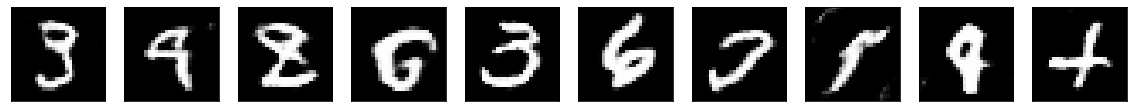

>> Images generated in epoch = 17:


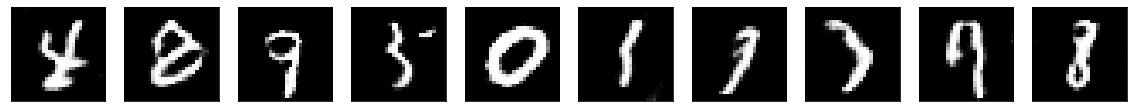

>> Images generated in epoch = 18:


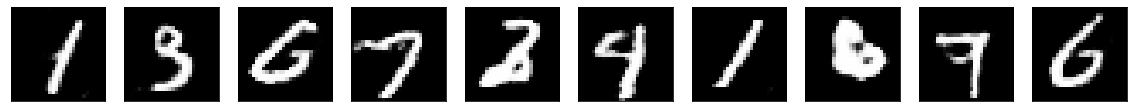

>> Images generated in epoch = 19:


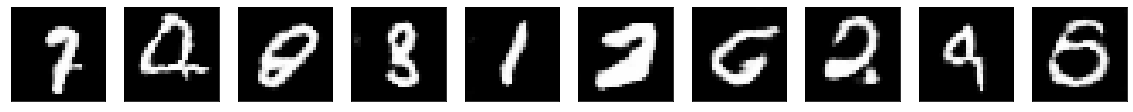

>> Images generated in epoch = 20:


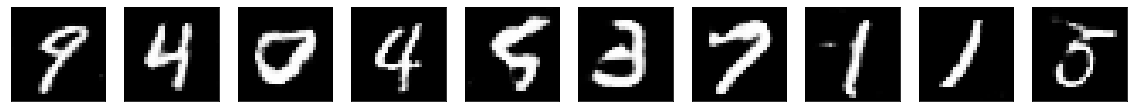

>> Images generated in epoch = 21:


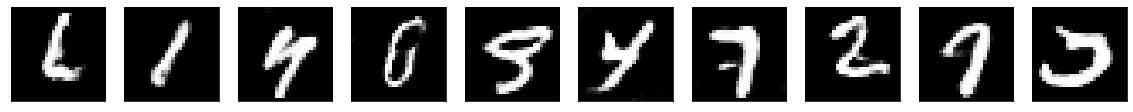

>> Images generated in epoch = 22:


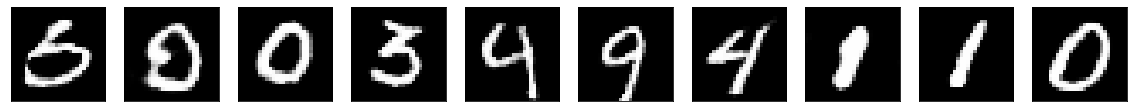

>> Images generated in epoch = 23:


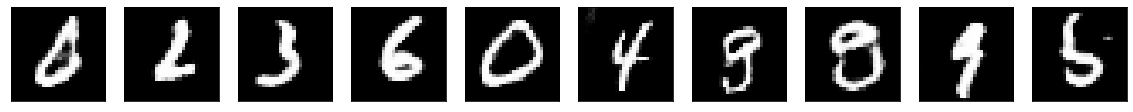

>> Images generated in epoch = 24:


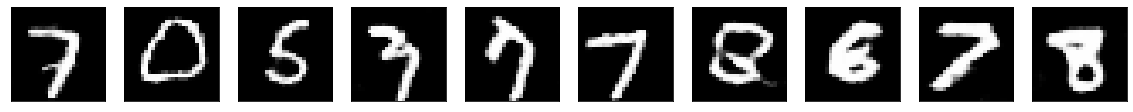

>> Images generated in epoch = 25:


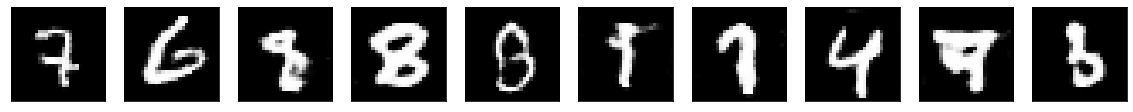

>> Images generated in epoch = 26:


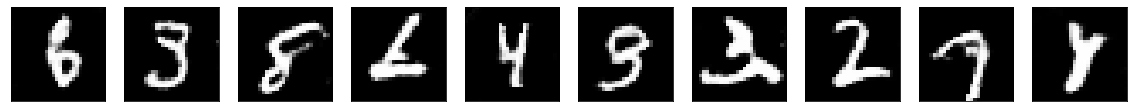

>> Images generated in epoch = 27:


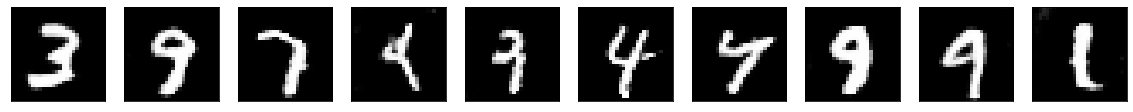

>> Images generated in epoch = 28:


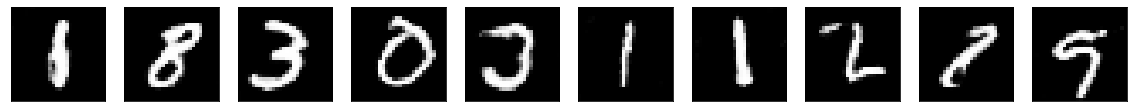

>> Images generated in epoch = 29:


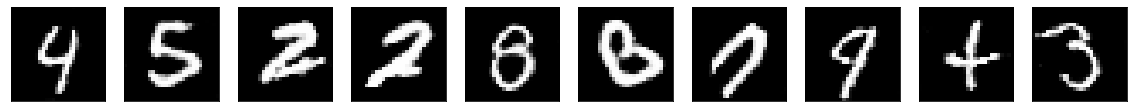

>> Images generated in epoch = 30:


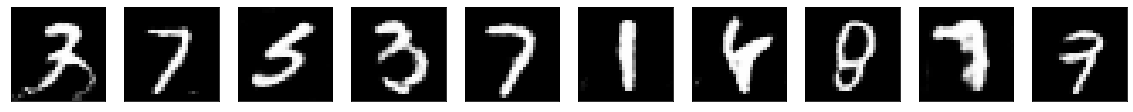

In [7]:
epochs = 30
dcgan = DeepConvGAN(discriminator = discriminator, generator = generator, latent_dim = latent_dim)
dcgan.compile(
    d_optimizer = keras.optimizers.Adam(learning_rate = 3e-4, beta_1 = 0.5), 
    g_optimizer = keras.optimizers.Adam(learning_rate = 3e-4, beta_1 = 0.5),
    loss_function = keras.losses.BinaryCrossentropy(),
)

history = dcgan.fit(
    dataset, 
    epochs = epochs, 
    callbacks = (DeepConvGANMonitor(num_img = 10, latent_dim = latent_dim),),
    verbose = 0
)

# 2. Sau khi train xong hãy viết một hàm sao cho khi đưa vào 4 lattent random vectors thì mô hình sẽ tạo ra 4 samples

In [8]:
def generate_samples(random_latent_vectors, dcgan_model):
    num_samples = random_latent_vectors.shape[0]
    generated_images = dcgan_model.generator(random_latent_vectors)
    generated_images = generated_images*127.5 + 127.5
    plt.close("all")
    fig, axes = plt.subplots(nrows = 1, ncols = num_samples, figsize = (20, num_samples))
    for i in range(num_samples):
        img = keras.preprocessing.image.array_to_img(generated_images[i])
        axes[i].imshow(img, cmap = plt.cm.gray)
        _ = axes[i].set(xticks = [], yticks = [])
    plt.show()

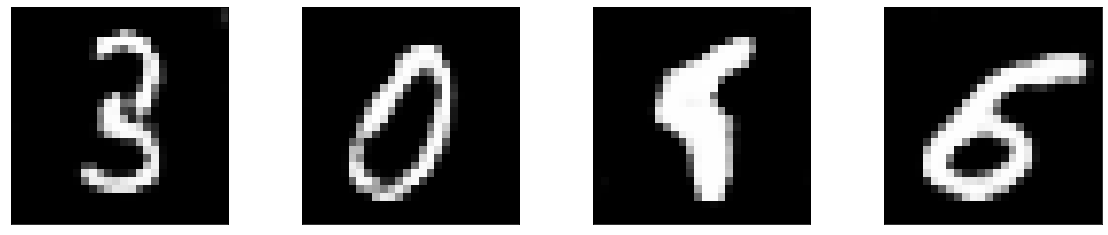

In [9]:
random_latent_vectors = tf.random.normal(shape = (4, latent_dim))
generate_samples(random_latent_vectors, dcgan)

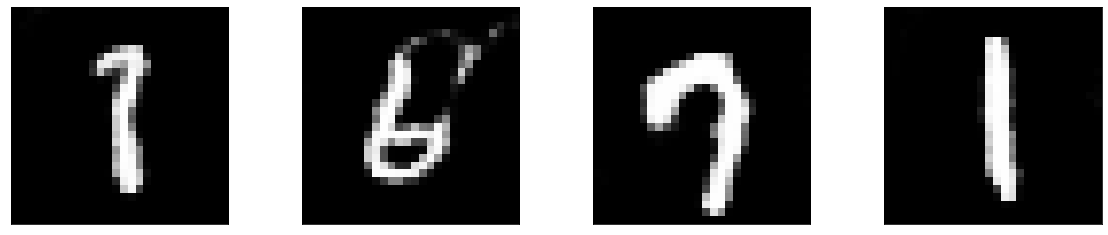

In [10]:
random_latent_vectors = tf.random.normal(shape = (4, latent_dim))
generate_samples(random_latent_vectors, dcgan)